In [6]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# saving
import joblib

# progress monitoring
from tqdm import tqdm

In [2]:
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

X_train.shape, y_train.shape

((36249, 18), (36249,))

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [12]:
svc = SVC()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
param_grid = [
    # Kernel linear
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    # Kernel RBF (Gaussiano)
    {
        'kernel': ['rbf'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
]

In [15]:
pipeline_param_grid = [
    # Kernel linear
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.01, 0.1, 1, 10, 100]
    },
    # Kernel RBF (Gaussiano)
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.01, 0.1, 1, 10, 100],
        'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
]

In [10]:
def train_random_search(X, y, estimator, grid, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=0,
        n_iter=n_iter
    )

    
    with tqdm(total=n_iter, desc="RandomizedSeachCV Progress") as pbar:
        random_search.fit(X, y)
        pbar.update(n_iter)

    return random_search

In [29]:
def get_results(r_search, pipeline=False):
    results = pd.DataFrame(r_search.cv_results_)
    
    if pipeline:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_svc__kernel', 'param_svc__C',
                'param_svc__gamma', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]
    else:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_kernel', 'param_C', 'param_gamma', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]


    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [16]:
rs = train_random_search(X_train, y_train, svc, param_grid, 20)

RandomizedSeachCV Progress: 100%|██████████| 20/20 [48:51<00:00, 146.57s/it]


In [19]:
results = get_results(rs)
results.head()

,mean_fit_time,mean_score_time,param_kernel,param_C,param_gamma,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
13,130.140527,5.650287,rbf,100,1,0.928853,0.908687,1,0.927335,0.906638,1,0.927003,0.906558,1,0.927167,0.906555,1
16,91.712267,7.516438,rbf,10,1,0.901885,0.891169,2,0.899917,0.888977,2,0.899097,0.888150,2,0.899496,0.888514,2
10,68.002786,7.182604,rbf,100,0.01,0.878455,0.877762,3,0.875190,0.874517,3,0.876612,0.875922,3,0.875862,0.875158,3
9,108.042407,1.782239,linear,10,NaN,0.874957,0.874866,4,0.871222,0.871154,4,0.874587,0.874522,5,0.872655,0.872564,4
12,298.047944,1.901339,linear,100,NaN,0.874872,0.874672,5,0.871069,0.870902,5,0.875024,0.874806,4,0.872685,0.872475,5


In [20]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame, pipeline: bool=False):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    if pipeline:
        param_cols = [
        'param_svc__kernel', 'param_svc__C', 'param_svc__gamma'
    ]
    else:
        param_cols = [
        'param_kernel', 'param_C', 'param_gamma'
    ]


    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(8, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

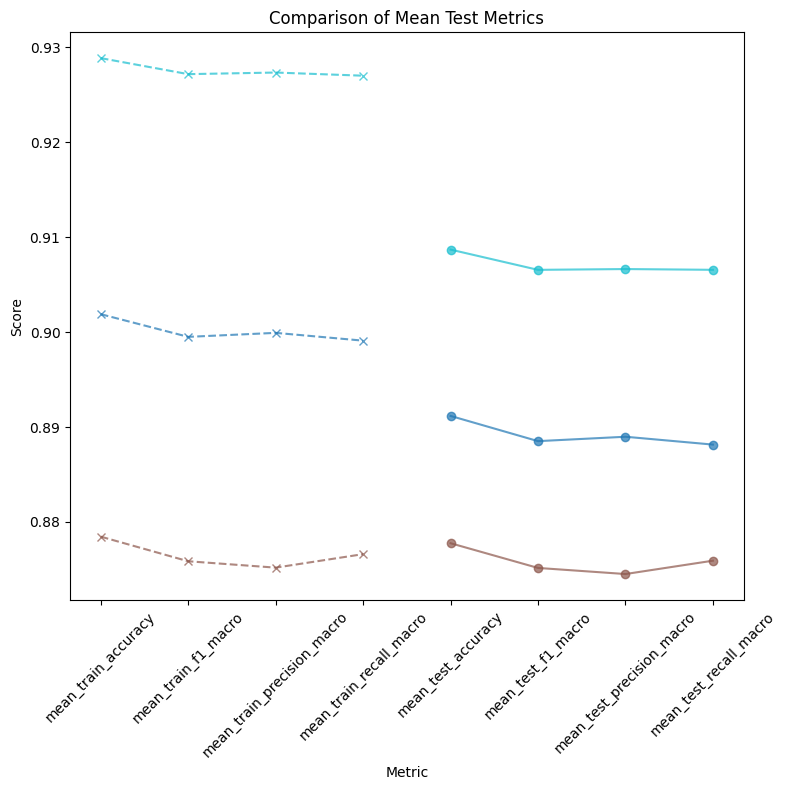

In [21]:
view_test_metrics(True, 3, results)

In [22]:
col_names = joblib.load('../data/cols.pkl')

C:\Users\caiop\AppData\Local\Temp\ipykernel_21744\984357541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


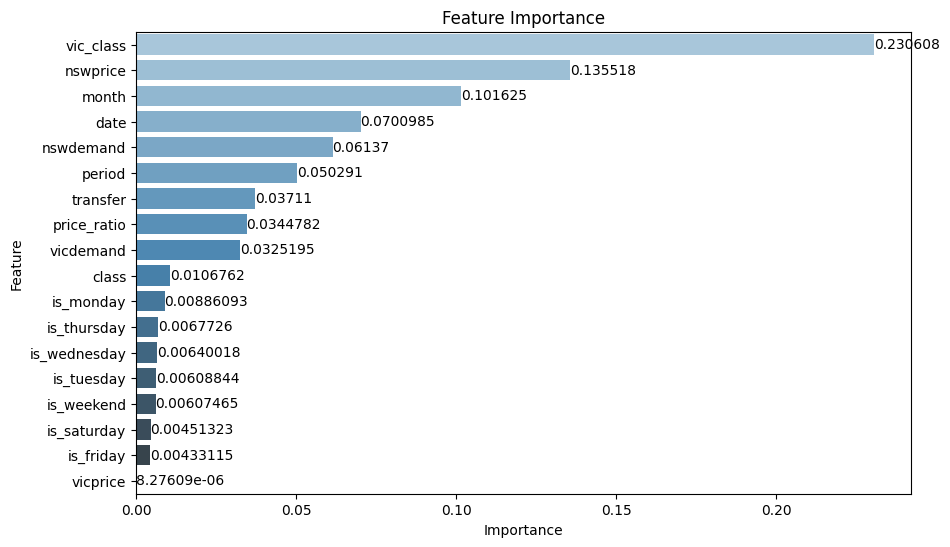

In [36]:
from sklearn.inspection import permutation_importance

def feature_importance(model):
    result = permutation_importance(
    estimator=model,       
    X=X_train,
    y=y_train,
    n_repeats=10,
    random_state=42
)

    importances = result.importances_mean
    importance_df = pd.DataFrame({
        'Feature': col_names[:-1],
        'Importance': importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title('Feature Importance')
    plt.show()
feature_importance(rs.best_estimator_)

## Testando balanceamento

In [26]:
ro_pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('svc', SVC())
])

In [27]:
ro_rs = train_random_search(X_train, y_train, ro_pipeline, pipeline_param_grid, 20)

RandomizedSeachCV Progress: 100%|██████████| 20/20 [1:07:48<00:00, 203.43s/it]


In [30]:
ro_results = get_results(ro_rs, True)
ro_results.head()

,mean_fit_time,mean_score_time,param_svc__kernel,param_svc__C,param_svc__gamma,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
17,140.582685,7.702341,rbf,10,1,0.900264,0.888604,1,0.896695,0.884970,1,0.901723,0.889816,1,0.898644,0.886794,1
9,96.572941,7.236946,rbf,100,0.01,0.876223,0.875417,2,0.872406,0.871635,2,0.877448,0.876620,2,0.874280,0.873459,2
18,121.703681,2.269462,linear,1,NaN,0.874574,0.874424,3,0.870760,0.870639,3,0.876077,0.875911,3,0.872671,0.872513,3
5,388.087418,1.806082,linear,100,NaN,0.872640,0.872521,4,0.869062,0.868994,4,0.875555,0.875475,4,0.870998,0.870881,4
12,156.473598,3.081730,linear,0.1,NaN,0.858129,0.857982,5,0.858806,0.858752,5,0.849572,0.849371,6,0.853105,0.852930,5


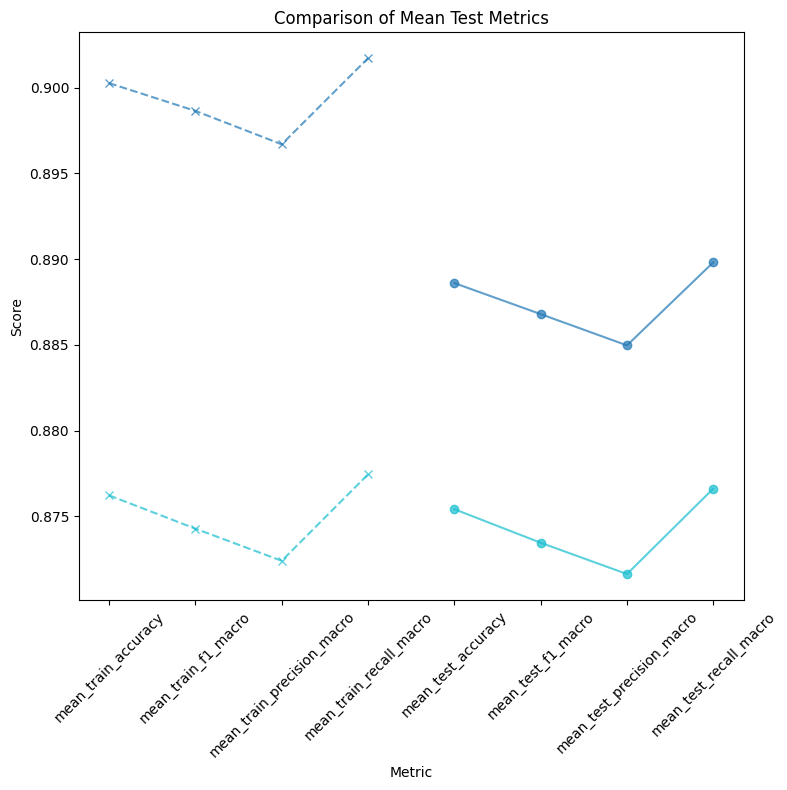

In [31]:
view_test_metrics(True, 3, ro_results, True)

C:\Users\caiop\AppData\Local\Temp\ipykernel_21744\984357541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


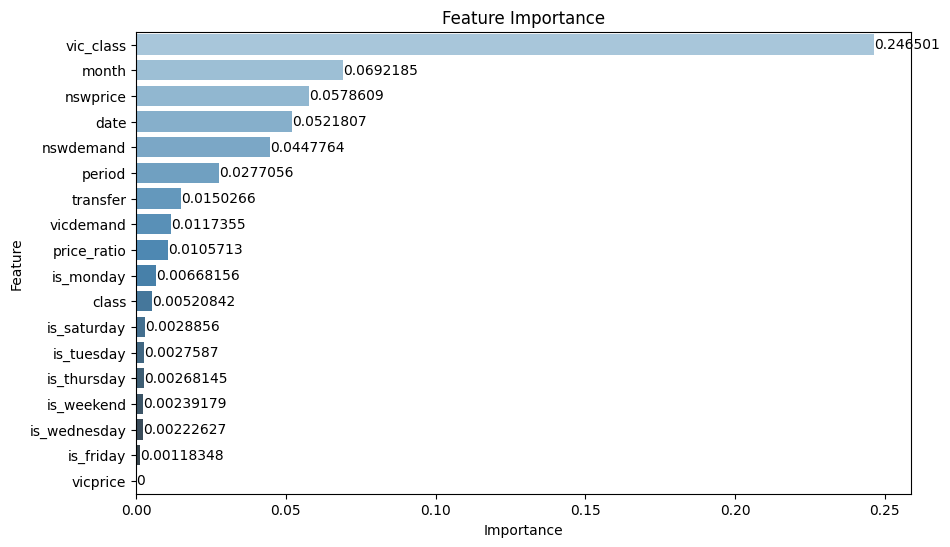

In [37]:
feature_importance(ro_rs.best_estimator_.named_steps['svc'])

In [32]:
preds = cross_val_predict(rs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

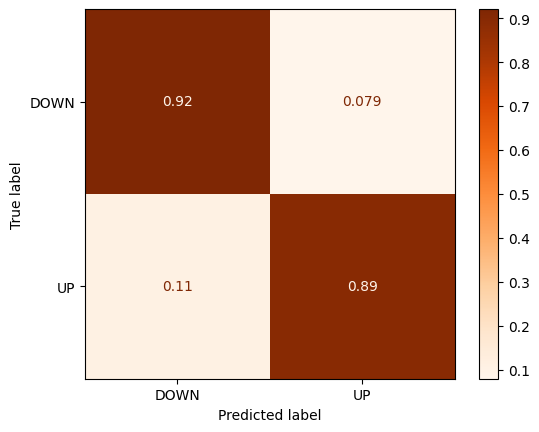

In [33]:
cm = confusion_matrix(y_train, preds, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN', 'UP'])
cmd.plot(cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [34]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9207    0.9207    0.9207     20860
           1     0.8925    0.8925    0.8925     15389

    accuracy                         0.9087     36249
   macro avg     0.9066    0.9066    0.9066     36249
weighted avg     0.9087    0.9087    0.9087     36249



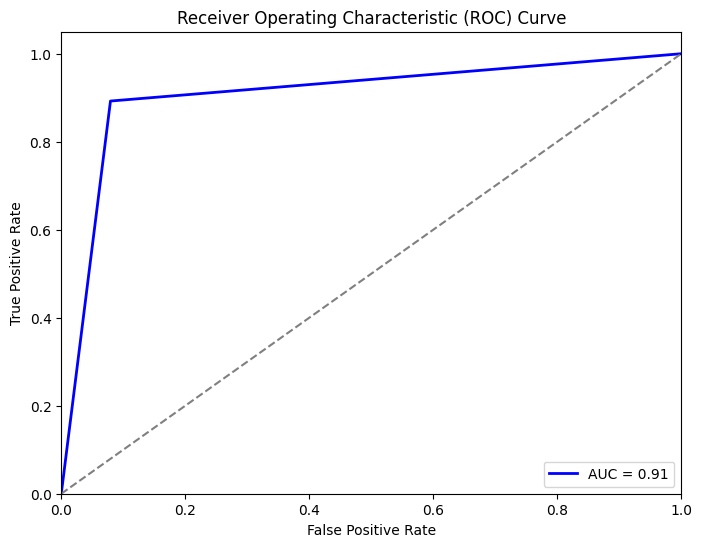

In [35]:
fpr, tpr, thresholds = roc_curve(y_train, preds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [38]:
joblib.dump(rs.best_estimator_, '../models/svm.pkl')

['../models/svm.pkl']